## Installation
Follow [Installation](docs/install.md) instruction.

## Import everything

In [3]:
%reload_ext autoreload

%autoreload 2

import os.path as osp
from omegaconf.omegaconf import OmegaConf
import logging 
logging.getLogger().setLevel(logging.ERROR)

import sys
sys.path.append('externals/frankmocap/')
sys.path.append('externals/frankmocap/detectors/body_pose_estimator/')

from config.defaults import get_cfg_defaults

from nnutils.hand_utils import ManopthWrapper
from nnutils.handmocap import get_handmocap_predictor, process_mocap_predictions, get_handmocap_detector
from nnutils.hoiapi import vis_hand_object, Predictor
from nnutils import model_utils
from nnutils import image_utils

from externals.frankmocap.mocap_utils.demo_utils import extract_mesh_from_output

import numpy as np
from PIL import Image

from renderer.screen_free_visualizer import Visualizer

import ipywidgets as widgets
import torch
assert torch.cuda.is_available()


## Loading an image

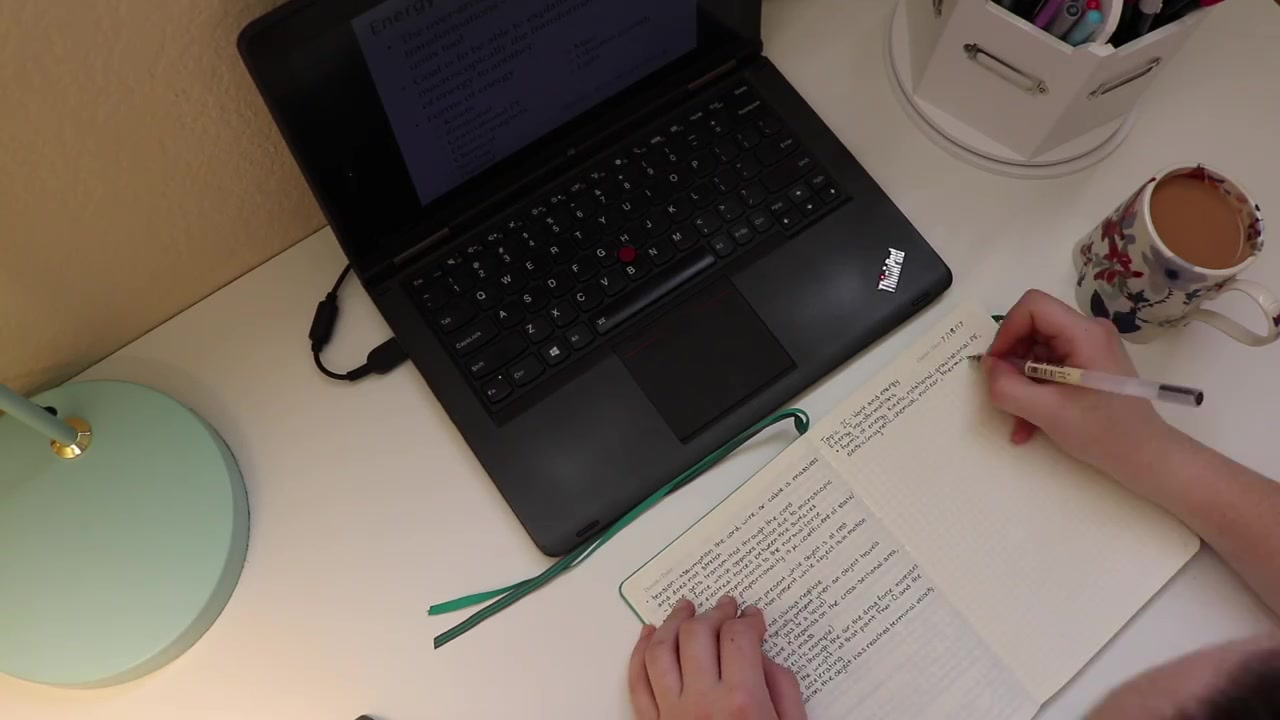

In [4]:
# read in an image
filename = 'demo/test.jpg'
image_pil = Image.open(filename).convert("RGB")
image = np.array(image_pil)
image_pil



## Hand Pose Estimation
1. Detect hand
2. Estimate hand pose

### Hand Detection
We support two ways to specify hand region. 
1. From detection system. Frankmocap integrates two hand detectors from [100DOH](https://fouheylab.eecs.umich.edu/~dandans/projects/100DOH/) where third-view and ego-centric models are trained separately. You need to specify it by yourself. 
2. Draw hand from UI. We found that  hand detection sometimes misses region of interests although the hand pose regression is quite robust for a hand crop. So we provide a UI to specify hand crop from user.

(Left hand supports are coming soon)

**From detection system**

Loading Body Pose Estimator
Loading Ego Centric Hand Detector


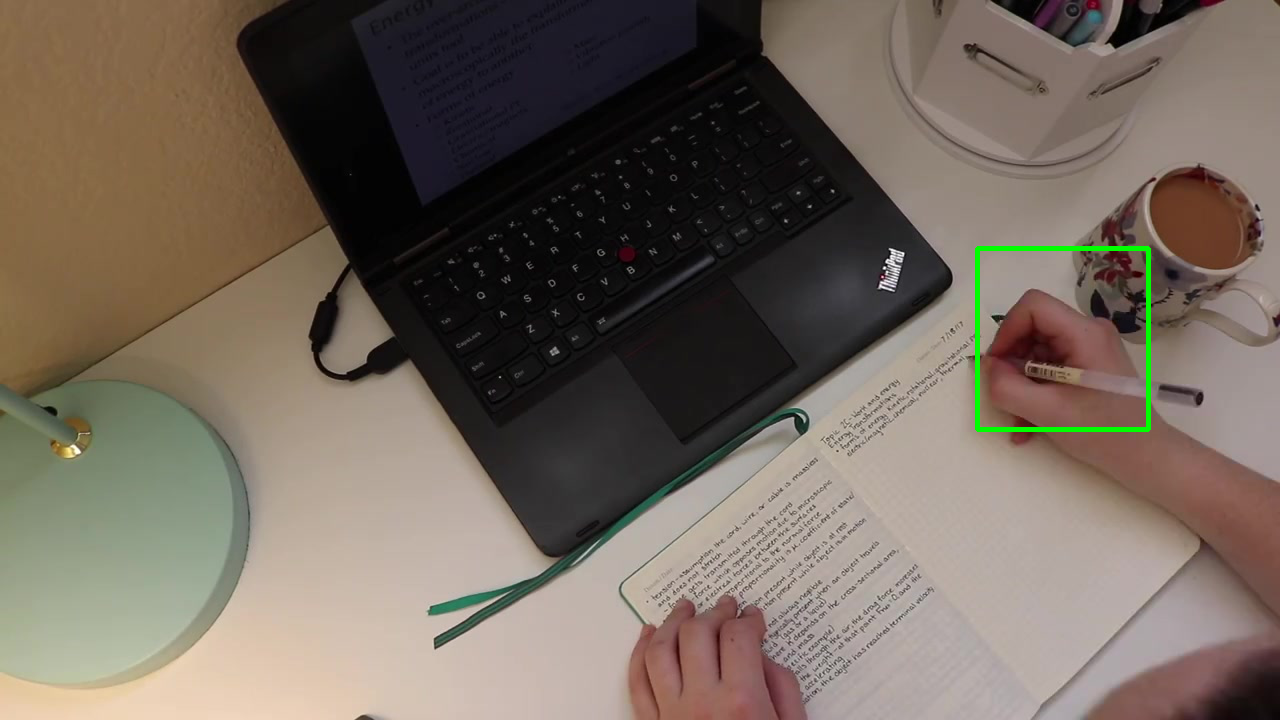

In [5]:
view_type = 'ego_centric'  # 'thrid_view'

object_mask = np.ones_like(image[..., 0])
visualizer = Visualizer('pytorch3d')
bbox_detector = get_handmocap_detector(view_type)

# Process Human Estimations.
detect_output = bbox_detector.detect_hand_bbox(image[..., ::-1].copy())
body_pose_list, body_bbox_list, hand_bbox_list, raw_hand_bboxes = detect_output

# visualize
res_img = visualizer.visualize(
    image, 
    hand_bbox_list = hand_bbox_list)


Image.fromarray(res_img.astype(np.uint8))



**From UI**: you may need to install widgets by `jupyter nbextension enable --py jupyter_bbox_widget`

In [6]:
import ipywidgets as widgets
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget(
    image=filename,
    classes=['right_hand'],
)
widget

BBoxWidget(classes=['right_hand'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '…

In [7]:
hand_bbox_list = [{'left_hand': None, 'right_hand': np.array([widget.bboxes[0]['x'], widget.bboxes[0]['y'], widget.bboxes[0]['width'], widget.bboxes[0]['height']])} ]

### Get object mask (Optional) 
The input scene is sometimes very cluttered to confuse the model what object to reconstruct. In order to better indicate the region of interests, our model pretrained on MOW takes in masks as additional channel. 
We provide a script `Box2Mask` to segment the object masks around the hand boxes. 
But overall, it is okay to fill in a placholder foreground masks (all 1). 

In [66]:
from nnutils import box2mask
mask_predictor = box2mask.setup_model()
boxes = torch.FloatTensor([ hand_bbox_list[0]['right_hand']])
boxes = BoxMode.convert(boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
predictions, object_mask = mask_predictor(image[..., ::-1], boxes, pad=0)

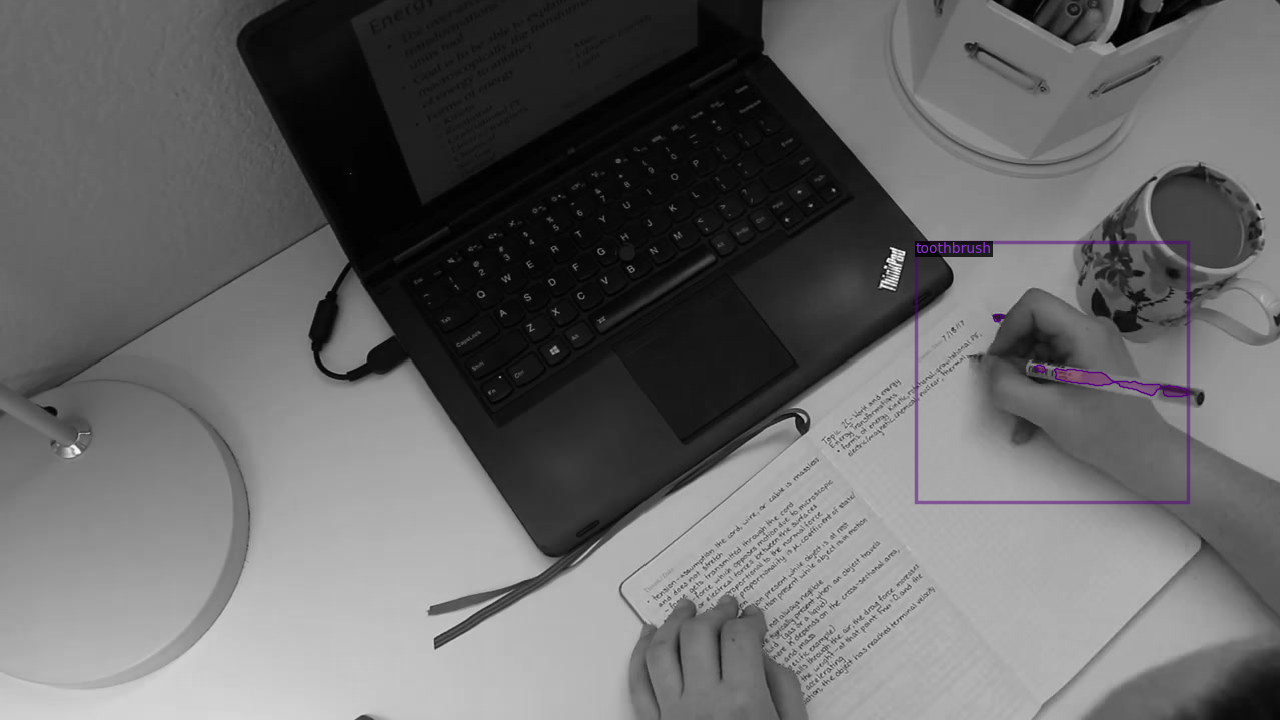

In [67]:
# visualize masks
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer as VisDet
from detectron2.structures.boxes import BoxMode
from detectron2.data import MetadataCatalog

coco_metadata = MetadataCatalog.get("coco_2017_val")
v = VisDet(image, coco_metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)
vis = v.draw_instance_predictions(predictions['instance'])

Image.fromarray(vis.get_image())

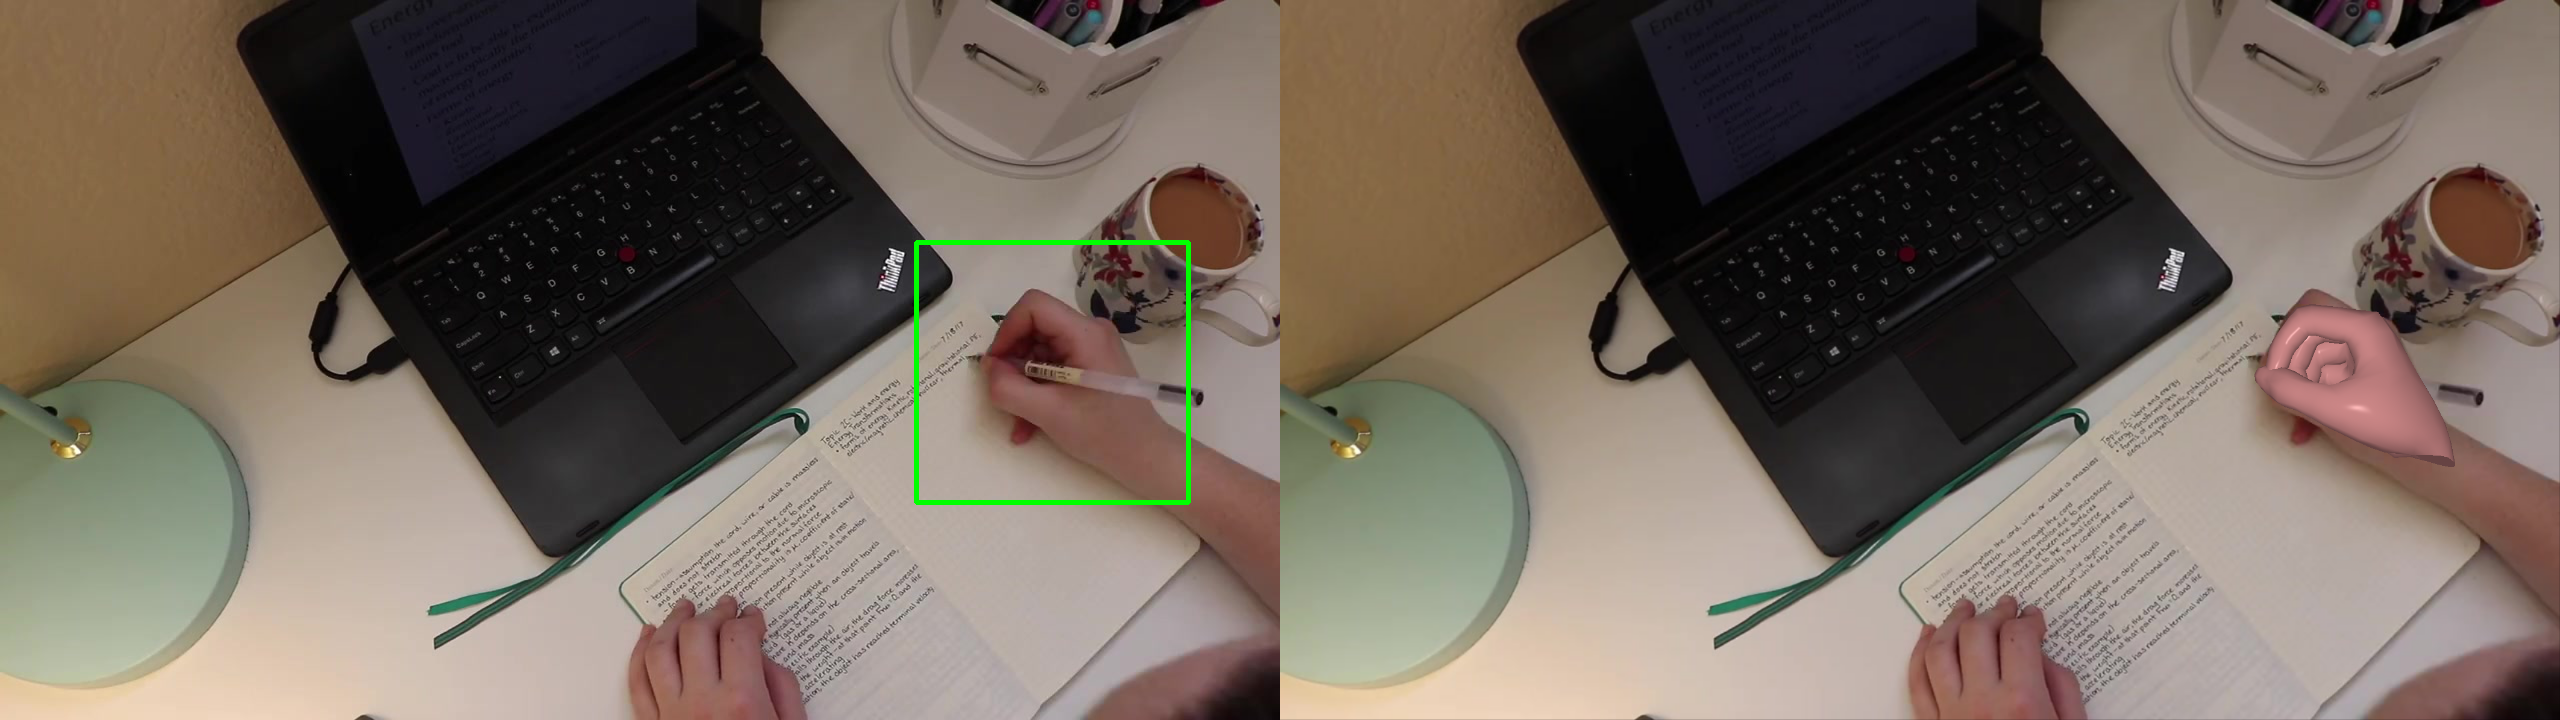

In [61]:

hand_predictor = get_handmocap_predictor()
mocap_predictions = hand_predictor.regress(
    image[..., ::-1], hand_bbox_list
)

hand_wrapper = ManopthWrapper().to('cpu')

pred_mesh_list = extract_mesh_from_output(mocap_predictions)

# visualize
res_img = visualizer.visualize(
    image, 
    pred_mesh_list = pred_mesh_list, 
    hand_bbox_list = hand_bbox_list)


Image.fromarray(res_img.astype(np.uint8))


In [11]:

def get_hoi_predictor(experiment_directory='weights/mow'):
    cfg_def = get_cfg_defaults()
    cfg_def = OmegaConf.create(cfg_def.dump())
    cfg = OmegaConf.load(osp.join(experiment_directory, 'hparams.yaml'))
    cfg = OmegaConf.merge(cfg_def, cfg)
    cfg.MODEL.BATCH_SIZE = 1
    model = model_utils.load_model(cfg, experiment_directory, 'last')

    predictor = Predictor(model)
    return predictor


In [70]:

data = process_mocap_predictions(
    mocap_predictions, image, hand_wrapper, mask=object_mask
)

out_dir = './output/'
hoi_predictor = get_hoi_predictor()
output = hoi_predictor.forward_to_mesh(data)


torch.Size([1, 3]) torch.Size([1, 21, 3])
torch.Size([1, 1, 224, 224])


save to  ./output//test_cHoi.gif
save meshes to  ./output//test_hoi


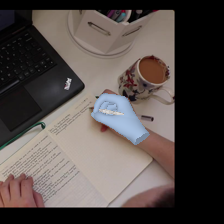

In [71]:
vis_hand_object(output, data, image, out_dir + '/test')
Image.open('output/test_cHoi.png')

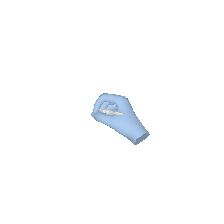

In [72]:
image_utils.display_gif('output/test_cHoi.gif')